In [1]:
#from image_env_mnist1 import Image_env1
from RL_saccader_x1 import DeepQNetwork
from RL_networks import Stand_alone_net
import numpy as np
import time
import pickle
import copy
import SYCLOP_env as syc
from misc import *
import sys
import os
import tensorflow as tf
import cv2
import json

hp=HP()
# if not os.path.exists(hp.this_run_path):
#     os.makedirs(hp.this_run_path)
# else:
#     error('run name already exists!')

hp.save_path = 'saved_runs'
hp.this_run_name = 'DELETEME_nb_' + '_noname_' + str(int(time.time()))
# hp.description = "only 2nd image from videos 1st frame, penalty for speed, soft q learning"
hp.description = "cnn on stills from movies, changed tau_int"
hp.mem_depth = 1
hp.max_episode = 1000
hp.steps_per_episode = 1000
hp.steps_between_learnings = 100
hp.steps_before_learning_begins = 100
hp.fading_mem = 0.0
hp.tau_int=4
hp.saccade_observation_scale = 100
hp.num_images = 200
recorder_file = 'records.pkl'
hp_file = 'hp.pkl'
hp.contrast_range = [1.0,1.1]
hp.dqn_initial_network = None # 'saved_runs/run_syclop_generic_cnn_vfb_neu.py_noname_1590422112_0/tempX_1.nwk'  # None #'saved_runs/run_syclop_generic_cnn_vfb_neu.py_noname_1589383850_0/tempX_1.nwk'
hp.grayscale = False
# hp.saccade_initial_network='saved_runs/run_saccader201.py_noname__try_resize_tau4__1616409975_993559_1/tempX_saccade.nwk'

# hp.drift_initial_network= 'saved_runs/run_saccader201.py_noname__try_resize_tau4__1616409975_993559_1/tempX_drift.nwk'  
hp.saccade_initial_network='saved_runs/run_saccader301.py_noname__1617839305_319150_1//tempX_saccade.nwk'

hp.drift_initial_network= 'saved_runs/run_saccader301.py_noname__1617839305_319150_1/tempX_drift.nwk'#
nchannels = 1 if hp.grayscale else 3
if not os.path.exists(hp.save_path):
    os.makedirs(hp.save_path)

dir_success = False
for sfx in range(1):  # todo legacy
    candidate_path = hp.save_path + '/' + hp.this_run_name + '_' + str(os.getpid()) + '/'
    if not os.path.exists(candidate_path):
        hp.this_run_path = candidate_path
        os.makedirs(hp.this_run_path)
        dir_success = True
        break
if not dir_success:
    error('run name already exists!')
def deploy_logs():
    sys.stdout = Logger(hp.this_run_path+'log.log')
    print('results are in:', hp.this_run_path)
    print('description: ', hp.description)
    print('hyper-parameters (partial):', hp)

def local_observer(sensor,agent,integrator):
    normfactor=1.0/256.0
    return np.concatenate([normfactor*sensor.dvs_view.reshape([-1]), agent.qdot, integrator.reshape([-1])],axis=0)

def saccade_observer(sensor,drift_observation):
    normfactor=1.0/256.0
    return np.concatenate([normfactor*sensor.frame_view.reshape([-1]), drift_observation.reshape([-1])],axis=0)

def drift_state_for_saccade_observation(current_state, integrator_state):
    return integrator_state

def drift_state_for_integrator(drift_net_state, abs_en=False,layer=5):
    if abs_en:
        return np.abs(drift_net_state[layer])
    else:
        return drift_net_state[layer]

def index_to_coord(i,xymax,offset=[0,0]):
    return [i%xymax[0]+offset[0],-(i//xymax[0]+offset[1])]

# def undistort_q_poly(dq,w,cm=None):
#     if cm is None:
#         cm = np.array([[0,0]])
#     xy = dq-cm
#     r = np.sqrt(np.sum(xy**2,axis=1))
#     powvec = np.array([list(range(len(w)))])
#     rnew = (r[..., np.newaxis]**powvec) @ w
#     xynew = xy *(rnew / r)[..., np.newaxis]
#     dqnew = xynew + cm
#     return dqnew

In [2]:
def label_from_filename(filename):
    label=''.join([uu+'_' for uu in filename.split('/')[-1].split('_')[:-1]])
    label=label[:-1]
    return label

In [3]:
with open('fisheye_102.pkl','rb') as f:
    fy_dict=pickle.load(f)

In [4]:
# if __name__ == "__main__":
recorder = Recorder(n=6)

#     images = read_images_from_path('/home/bnapp/arivkindNet/video_datasets/stills_from_videos/some100img_from20bn/*',max_image=hp.num_images)
images = prep_mnist_sparse_images(10,images_per_scene=20)
# images = read_images_from_path('/home/labs/ahissarlab/arivkind/video_datasets/stills_from_videos/some100img_from20bn/*',max_image=hp.num_images)

# with open('../video_datasets/liron_images/shuffled_images.pkl', 'rb') as f:
#     images = pickle.load(f)
print(len(images))
scene = syc.Scene(frame_list=images)
sensor = syc.Sensor( fisheye=fy_dict,centralwinx=32,centralwiny=32,nchannels=nchannels)
saccade_agent = syc.Saccadic_Agent(max_q = [scene.maxx-sensor.hp.winx,scene.maxy-sensor.hp.winy])

reward = syc.Rewards(reward_types=['network'],relative_weights=[100.0])
# observation_size = sensor.hp.winx*sensor.hp.winy*2
saccade_observation_size = 64*64*nchannels+200
n_features_shaped = list(np.shape(sensor.dvs_view))
if len(n_features_shaped)<3: # to support 2 and 3d dvs views
    n_features_shaped.append(nchannels) 

# saccade_RL = DeepQNetwork(np.prod(saccade_agent.max_q), saccade_observation_size,
saccade_RL=DeepQNetwork(64*64, saccade_observation_size,
                  n_features_shaped=n_features_shaped,
                  shape_fun= None,
                  reward_decay=0.99,
                  replace_target_iter=10,
                  memory_size=10000,
                  e_greedy_increment=0.0001,
                  learning_rate=0.0025,
                  double_q=True,
                  dqn_mode=True,
                  soft_q_type='boltzmann',
                  beta_schedule=[[1, 10]],#[[4000, 0.1], [7000, 1.0]],
                  arch='conv_saccades_v1',
                   n_modulating_features=200      
                  )
# at this point drift network is a standalone network taken from some external source (e.g. pretrained)
# in future it will be an action generating network from the drift loop
drift_net = Stand_alone_net([32, 32, 3], 10, arch='conv',
                            layer_size=[None] + [[5, 5, 96], [5, 5, 80], [5, 5, 64], [5, 5, 64]] + [200] + [None],
                            loss_type='softmax_cross_entropy',
                            trainable=True,
                            lr=1,
                            dropout_p_keep=0.99,
                            lambda_reg=0.0)
drift_net.assign_session_to_nwk(saccade_RL.dqn.sess)
saccade_RL.dqn.sess.run(tf.global_variables_initializer())
saccade_RL.dqn.reset()
#     if not(hp.dqn_initial_network is None):
saccade_RL.dqn.load_nwk_param(hp.saccade_initial_network)
drift_net.load_nwk_param(hp.drift_initial_network)
hp.scene = scene.hp
hp.sensor = sensor.hp
hp.saccade_agent = saccade_agent.hp
hp.reward = reward.hp
hp.saccade_RL = saccade_RL.hp
#     deploy_logs()
#     with open(hp.this_run_path+hp_file, 'wb') as f:
#         pickle.dump(hp, f)
#     run_env()
#     print('results are in:', hp.this_run_path)

10
debug n_features: [64, 64, 3]
debu: [64, 64, 32]
debudebu layer_shape: (?, 64, 64, 32)
debu: [64, 64, 32]
debug: (?, 200)
debug: (?, 30)
debug: (?, 32)
debudebu layer_shape: (?, 64, 64, 32)
debu: [64, 64, 1]
debudebu layer_shape: (?, 64, 64, 1)
debug n_features: [64, 64, 3]
debu: [64, 64, 32]
debudebu layer_shape: (?, 64, 64, 32)
debu: [64, 64, 32]
debug: (?, 200)
debug: (?, 30)
debug: (?, 32)
debudebu layer_shape: (?, 64, 64, 32)
debu: [64, 64, 1]
debudebu layer_shape: (?, 64, 64, 1)
debug SESSSS!!!!
debug SESSSS!!!!
debug n_features: [32, 32, 3]
debu: [32, 32, 96]
debu: [16, 16, 80]
debu: [8, 8, 64]
debu: [4, 4, 64]
debug: (?, 256)
debug: (?, 200)
debug SESSSS!!!!


In [5]:
def run_saccade_loop(image,steps,debug=False):
    saccade_observation = 0*np.random.uniform(0,1,size=[hp.mem_depth, saccade_observation_size])
    scene=syc.Scene(image_matrix = image)
    print('debuu-----',scene.image.shape,'-----',np.shape(sensor.dvs_view))
    integrator_state = 0
    saccade_action=64*32+32
    saccade_agent.reset(
    q_reset=np.array([100,100]),
    max_q = [scene.maxx-sensor.hp.winx,scene.maxy-sensor.hp.winy])


    local_q_recorder=[]
    local_driftstate_recorder=[]
    local_integrator_recorder=[]
#     saccade_agent.reset(q_reset=[np.random.randint(saccade_agent.max_q[0]+1),
#                                  np.random.randint(saccade_agent.max_q[1]+1)])
    saccade_agent.reset(q_reset=[saccade_agent.max_q[0]//2,
                             saccade_agent.max_q[1]//2])
    for step_prime in range(steps):

        local_q_recorder.append(0+saccade_agent.q)

        drift_net_state = drift_net.eval_incl_layers(1./256 *sensor.central_frame_view.reshape([1,32,32,nchannels])) #todo - change to some integrated version of the DVS view when adding the drift loop
        high_pass_layer = drift_state_for_integrator(drift_net_state) - integrator_state
        integrator_state = (1-1./hp.tau_int)*integrator_state+(1./hp.tau_int)*drift_state_for_integrator(drift_net_state)
        reward.update_rewards(sensor=sensor, agent=saccade_agent, network=high_pass_layer)
        saccade_RL.store_transition(saccade_observation.reshape([-1]), saccade_action, reward.reward)
        saccade_observation = hp.saccade_observation_scale*saccade_observer(sensor,
                                               drift_state_for_saccade_observation(drift_net_state,integrator_state))
        saccade_action, ent = saccade_RL.choose_action(saccade_observation.reshape([-1]),
                                                       discard_black_areas=True, 
                                                       black_area=(sensor.frame_view.max(axis=2)>1e-9))

        local_driftstate_recorder.append(0.+drift_state_for_integrator(drift_net_state))
        local_integrator_recorder.append(0.+integrator_state)

#         running_ave_reward = 0.999*running_ave_reward+0.001*np.array([reward.reward]+reward.rewards.tolist())
        # print('testing printout: reward:',reward.reward,' coord' ,saccade_agent.q,'\n')
        dq = index_to_coord(saccade_action,sensor.frame_view.shape,offset=[-31,-31])
        dq_rescaled = undistort_q_poly(dq,fy_dict['w']).squeeze().astype(np.int64)
#         print(index_to_coord(saccade_action,sensor.frame_view.shape,offset=[-31,-31]),dq,dq_rescaled)

        saccade_agent.act(dq_rescaled)
    #         print('----',saccade_agent.q)
        uu = saccade_observation[np.newaxis, :]

        sensor.update(scene,saccade_agent)
        if debug:
            plt.figure()
            plt.imshow(sensor.frame_view,cmap='gray')
    return local_q_recorder, local_driftstate_recorder,local_integrator_recorder      



In [6]:
n_features_shaped

[64, 64, 3]

In [7]:
sf_path = '/home/bnapp/datasets/Stanford40/JPEGImages/*'
label_counter={}
filenames = sorted(glob.glob(sf_path))
for filename in filenames:
    label=label_from_filename(filename)
    if label not in label_counter.keys():
        label_counter[label] = 1
    else:
        label_counter[label] += 1

In [8]:
db_dir='saccade_ds_fy_fy2_CIFAR201colorFullRe0p5_tau4_20stp'
if not os.path.exists(db_dir):
        os.makedirs(db_dir)
        os.makedirs(db_dir+'/DATA/')
        os.makedirs(db_dir+'/META/') 

debuu----- (264, 214, 3) ----- (64, 64, 3)


/home/bnapp/arivkindNet/rlnet1/RL_saccader_x1.py:178: RuntimeWarning: divide by zero encountered in log
  entropy = np.sum(-boltzmann_measure*np.log(boltzmann_measure))
/home/bnapp/arivkindNet/rlnet1/RL_saccader_x1.py:178: RuntimeWarning: invalid value encountered in multiply
  entropy = np.sum(-boltzmann_measure*np.log(boltzmann_measure))


debuu----- (214, 274, 3) ----- (64, 64, 3)
debuu----- (214, 297, 3) ----- (64, 64, 3)
debuu----- (272, 214, 3) ----- (64, 64, 3)
debuu----- (289, 214, 3) ----- (64, 64, 3)
debuu----- (264, 331, 3) ----- (64, 64, 3)
debuu----- (264, 269, 3) ----- (64, 64, 3)
debuu----- (214, 289, 3) ----- (64, 64, 3)
debuu----- (164, 197, 3) ----- (64, 64, 3)
debuu----- (202, 164, 3) ----- (64, 64, 3)
debuu----- (464, 364, 3) ----- (64, 64, 3)


/usr/local/lib/python3.5/dist-packages/matplotlib/pyplot.py:514: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


debuu----- (214, 264, 3) ----- (64, 64, 3)
debuu----- (282, 214, 3) ----- (64, 64, 3)
debuu----- (214, 288, 3) ----- (64, 64, 3)
debuu----- (164, 215, 3) ----- (64, 64, 3)
debuu----- (164, 242, 3) ----- (64, 64, 3)
debuu----- (264, 364, 3) ----- (64, 64, 3)
debuu----- (214, 264, 3) ----- (64, 64, 3)
debuu----- (264, 363, 3) ----- (64, 64, 3)
debuu----- (264, 270, 3) ----- (64, 64, 3)
debuu----- (266, 214, 3) ----- (64, 64, 3)
debuu----- (214, 238, 3) ----- (64, 64, 3)


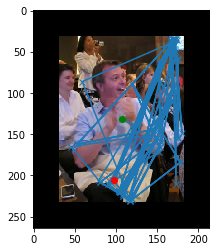

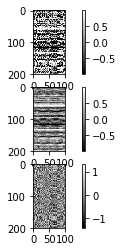

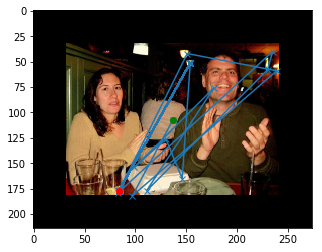

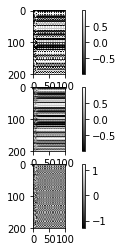

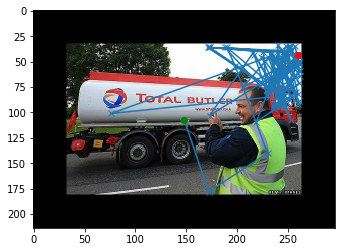

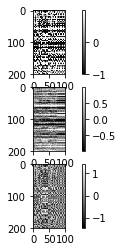

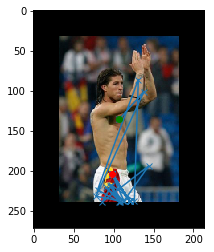

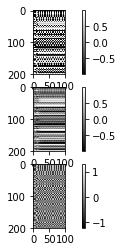

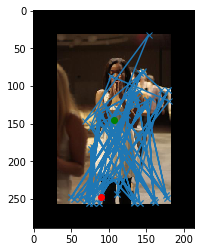

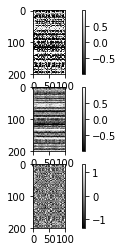

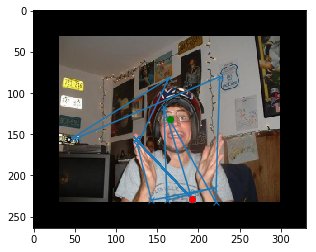

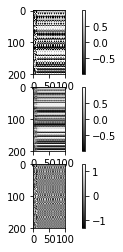

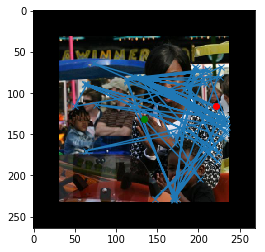

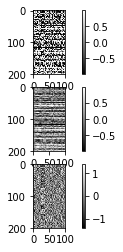

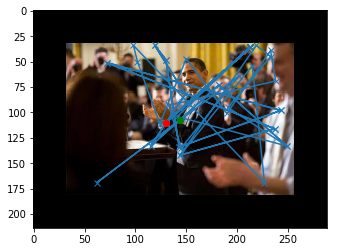

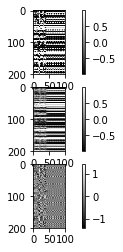

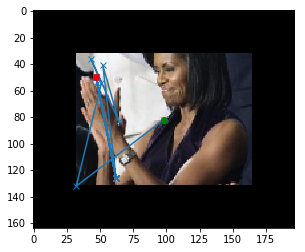

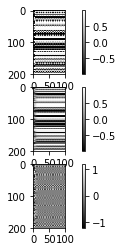

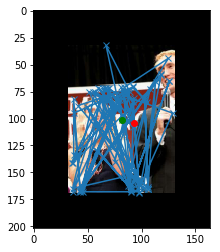

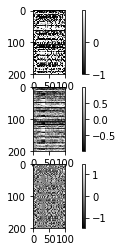

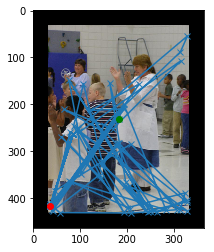

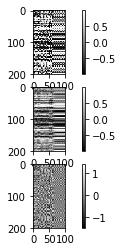

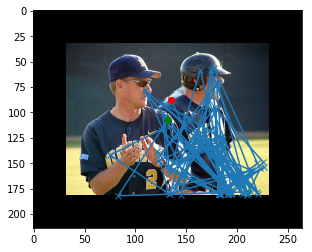

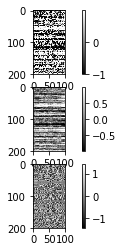

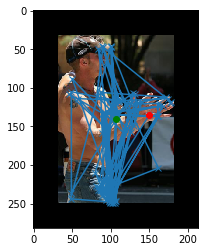

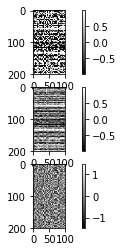

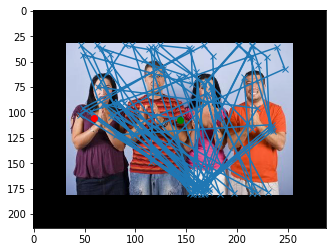

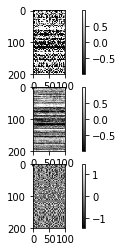

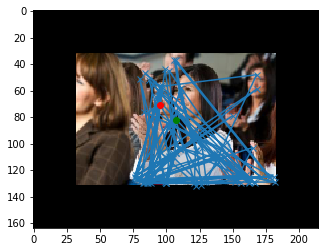

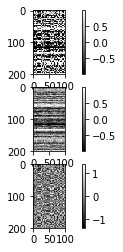

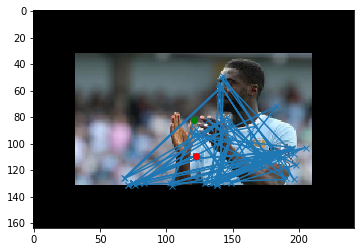

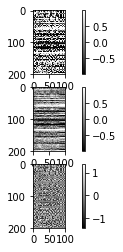

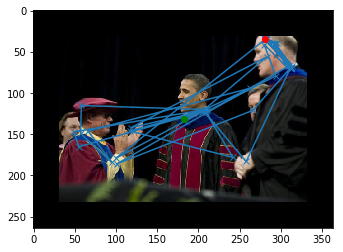

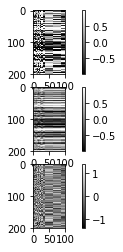

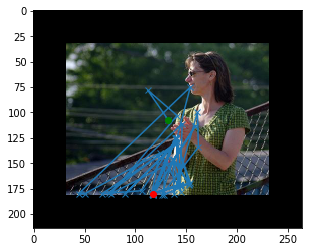

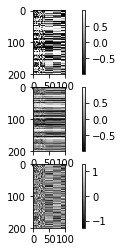

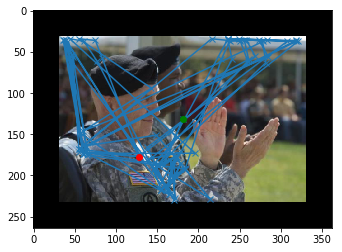

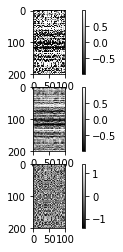

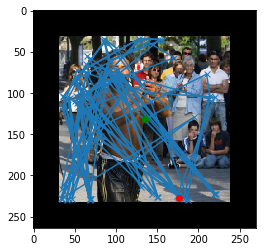

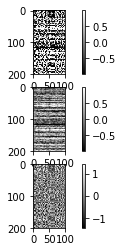

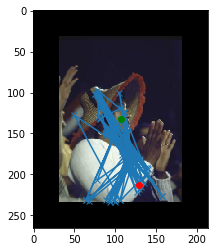

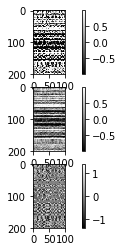

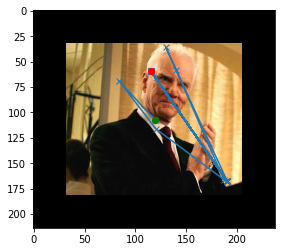

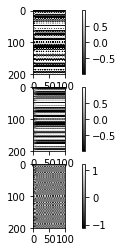

In [9]:
for ii,filename in enumerate(filenames):
    image,_ = read_random_image_from_path(filename, grayscale=hp.grayscale, padding=[32,32],resize=0.5)
#     image,_ = read_random_image_from_path(filename, grayscale=hp.grayscale, padding=None,resize=0.5)

    local_q_recorder, local_driftstate_recorder,local_integrator_recorder = run_saccade_loop(image,100)
    plt.figure()
    plt.imshow(image/256.)
    qqnp=np.array(local_q_recorder)
    maxy=image.shape[0]
    plt.plot(32+qqnp[:,0],maxy-32-qqnp[:,1],'x-')
    plt.plot(32+qqnp[0,0],maxy-32-qqnp[0,1],'go')
    plt.plot(32+qqnp[-1,0],maxy-32-qqnp[-1,1],'ro')
    
    drift_state=np.array(local_driftstate_recorder).squeeze()
    integrated_drift_state=np.array(local_integrator_recorder).squeeze()
    high_pass_drift_state=drift_state - integrated_drift_state
    plt.figure()
    plt.subplot(3,1,1)
    plt.imshow(drift_state.transpose(),cmap='gray')
    plt.colorbar()
    plt.subplot(3,1,2)
    plt.imshow(integrated_drift_state.transpose(),cmap='gray')
    plt.colorbar()

    plt.subplot(3,1,3)
    plt.imshow(high_pass_drift_state.transpose(),cmap='gray')
    plt.colorbar()

    if ii>20:
        break

In [11]:
label_to_num={l:ii for ii,l in enumerate(sorted(label_counter.keys()))}

In [12]:
#differences instead of absolute locations ~42% accuracy - just a bit above the no location setting
n_glimpse=20
mock_location=False
labels={'standard':{}}
for ii,filename in enumerate(filenames):
    image,_ = read_random_image_from_path(filename, grayscale=hp.grayscale, padding=[32,32],resize=0.5)
    if len(image.shape)==2:
        image = np.repeat(image[...,np.newaxis],3,axis=2)
        print('bum')
    local_q_recorder, local_driftstate_recorder,local_integrator_recorder = run_saccade_loop(image,n_glimpse)
    if mock_location:
        local_q_recorder = np.random.normal(size=np.shape(local_q_recorder))
    uu2=[np.reshape(uu,[np.shape(uu)[0],1,-1]) for uu in [local_q_recorder, local_driftstate_recorder,local_integrator_recorder]]
    data=np.concatenate(uu2,axis=2)
    np.save(db_dir+'/DATA/{}.npy'.format(str(ii)),
           data.transpose([0,2,1]))
#     strtpt_=strtpt*1.0
    labels['standard'][str(ii)]=label_to_num[label_from_filename(filename)]
#     if ii>20:
#         break
    if not ii%100:
        print(ii)

debuu----- (264, 214, 3) ----- (64, 64, 3)
0
debuu----- (214, 274, 3) ----- (64, 64, 3)
debuu----- (214, 297, 3) ----- (64, 64, 3)
debuu----- (272, 214, 3) ----- (64, 64, 3)
debuu----- (289, 214, 3) ----- (64, 64, 3)
debuu----- (264, 331, 3) ----- (64, 64, 3)
debuu----- (264, 269, 3) ----- (64, 64, 3)
debuu----- (214, 289, 3) ----- (64, 64, 3)
debuu----- (164, 197, 3) ----- (64, 64, 3)
debuu----- (202, 164, 3) ----- (64, 64, 3)
debuu----- (464, 364, 3) ----- (64, 64, 3)
debuu----- (214, 264, 3) ----- (64, 64, 3)
debuu----- (282, 214, 3) ----- (64, 64, 3)
debuu----- (214, 288, 3) ----- (64, 64, 3)
debuu----- (164, 215, 3) ----- (64, 64, 3)
debuu----- (164, 242, 3) ----- (64, 64, 3)
debuu----- (264, 364, 3) ----- (64, 64, 3)
debuu----- (214, 264, 3) ----- (64, 64, 3)
debuu----- (264, 363, 3) ----- (64, 64, 3)
debuu----- (264, 270, 3) ----- (64, 64, 3)
debuu----- (266, 214, 3) ----- (64, 64, 3)
debuu----- (214, 238, 3) ----- (64, 64, 3)
debuu----- (214, 264, 3) ----- (64, 64, 3)
debuu----

debuu----- (253, 214, 3) ----- (64, 64, 3)
debuu----- (335, 264, 3) ----- (64, 64, 3)
debuu----- (289, 214, 3) ----- (64, 64, 3)
debuu----- (264, 312, 3) ----- (64, 64, 3)
debuu----- (289, 214, 3) ----- (64, 64, 3)
debuu----- (252, 214, 3) ----- (64, 64, 3)
debuu----- (289, 214, 3) ----- (64, 64, 3)
debuu----- (264, 214, 3) ----- (64, 64, 3)
debuu----- (350, 264, 3) ----- (64, 64, 3)
debuu----- (214, 164, 3) ----- (64, 64, 3)
200
debuu----- (214, 289, 3) ----- (64, 64, 3)
debuu----- (214, 241, 3) ----- (64, 64, 3)
debuu----- (289, 214, 3) ----- (64, 64, 3)
debuu----- (233, 164, 3) ----- (64, 64, 3)
debuu----- (289, 214, 3) ----- (64, 64, 3)
debuu----- (214, 289, 3) ----- (64, 64, 3)
debuu----- (333, 264, 3) ----- (64, 64, 3)
debuu----- (214, 289, 3) ----- (64, 64, 3)
debuu----- (164, 215, 3) ----- (64, 64, 3)
debuu----- (314, 374, 3) ----- (64, 64, 3)
debuu----- (214, 289, 3) ----- (64, 64, 3)
debuu----- (314, 439, 3) ----- (64, 64, 3)
debuu----- (524, 364, 3) ----- (64, 64, 3)
debuu--

debuu----- (242, 164, 3) ----- (64, 64, 3)
debuu----- (289, 214, 3) ----- (64, 64, 3)
debuu----- (214, 256, 3) ----- (64, 64, 3)
debuu----- (214, 264, 3) ----- (64, 64, 3)
debuu----- (289, 214, 3) ----- (64, 64, 3)
debuu----- (264, 277, 3) ----- (64, 64, 3)
debuu----- (214, 274, 3) ----- (64, 64, 3)
debuu----- (214, 289, 3) ----- (64, 64, 3)
debuu----- (214, 287, 3) ----- (64, 64, 3)
debuu----- (331, 264, 3) ----- (64, 64, 3)
debuu----- (214, 289, 3) ----- (64, 64, 3)
debuu----- (264, 214, 3) ----- (64, 64, 3)
debuu----- (214, 264, 3) ----- (64, 64, 3)
debuu----- (259, 214, 3) ----- (64, 64, 3)
debuu----- (214, 264, 3) ----- (64, 64, 3)
debuu----- (214, 289, 3) ----- (64, 64, 3)
debuu----- (314, 345, 3) ----- (64, 64, 3)
debuu----- (289, 214, 3) ----- (64, 64, 3)
debuu----- (264, 214, 3) ----- (64, 64, 3)
400
debuu----- (214, 264, 3) ----- (64, 64, 3)
debuu----- (264, 214, 3) ----- (64, 64, 3)
debuu----- (260, 214, 3) ----- (64, 64, 3)
debuu----- (364, 439, 3) ----- (64, 64, 3)
debuu--

debuu----- (208, 164, 3) ----- (64, 64, 3)
debuu----- (364, 264, 3) ----- (64, 64, 3)
debuu----- (204, 164, 3) ----- (64, 64, 3)
debuu----- (364, 464, 3) ----- (64, 64, 3)
debuu----- (214, 214, 3) ----- (64, 64, 3)
debuu----- (214, 290, 3) ----- (64, 64, 3)
debuu----- (264, 314, 3) ----- (64, 64, 3)
debuu----- (255, 214, 3) ----- (64, 64, 3)
debuu----- (364, 464, 3) ----- (64, 64, 3)
debuu----- (264, 331, 3) ----- (64, 64, 3)
debuu----- (264, 331, 3) ----- (64, 64, 3)
debuu----- (331, 264, 3) ----- (64, 64, 3)
debuu----- (364, 464, 3) ----- (64, 64, 3)
debuu----- (214, 264, 3) ----- (64, 64, 3)
debuu----- (292, 264, 3) ----- (64, 64, 3)
debuu----- (214, 264, 3) ----- (64, 64, 3)
debuu----- (264, 214, 3) ----- (64, 64, 3)
debuu----- (264, 331, 3) ----- (64, 64, 3)
debuu----- (214, 289, 3) ----- (64, 64, 3)
debuu----- (214, 264, 3) ----- (64, 64, 3)
debuu----- (214, 264, 3) ----- (64, 64, 3)
debuu----- (331, 264, 3) ----- (64, 64, 3)
debuu----- (214, 264, 3) ----- (64, 64, 3)
debuu----- 

debuu----- (283, 214, 3) ----- (64, 64, 3)
debuu----- (366, 264, 3) ----- (64, 64, 3)
debuu----- (258, 214, 3) ----- (64, 64, 3)
debuu----- (214, 264, 3) ----- (64, 64, 3)
debuu----- (187, 164, 3) ----- (64, 64, 3)
debuu----- (290, 264, 3) ----- (64, 64, 3)
debuu----- (264, 334, 3) ----- (64, 64, 3)
debuu----- (264, 214, 3) ----- (64, 64, 3)
debuu----- (264, 366, 3) ----- (64, 64, 3)
debuu----- (214, 264, 3) ----- (64, 64, 3)
debuu----- (197, 164, 3) ----- (64, 64, 3)
debuu----- (264, 214, 3) ----- (64, 64, 3)
debuu----- (272, 214, 3) ----- (64, 64, 3)
debuu----- (289, 214, 3) ----- (64, 64, 3)
debuu----- (264, 214, 3) ----- (64, 64, 3)
debuu----- (214, 264, 3) ----- (64, 64, 3)
debuu----- (190, 164, 3) ----- (64, 64, 3)
debuu----- (364, 464, 3) ----- (64, 64, 3)
debuu----- (214, 289, 3) ----- (64, 64, 3)
debuu----- (214, 295, 3) ----- (64, 64, 3)
debuu----- (264, 214, 3) ----- (64, 64, 3)
debuu----- (214, 264, 3) ----- (64, 64, 3)
debuu----- (214, 291, 3) ----- (64, 64, 3)
debuu----- 

debuu----- (289, 214, 3) ----- (64, 64, 3)
debuu----- (367, 264, 3) ----- (64, 64, 3)
debuu----- (188, 164, 3) ----- (64, 64, 3)
debuu----- (188, 164, 3) ----- (64, 64, 3)
debuu----- (214, 264, 3) ----- (64, 64, 3)
debuu----- (364, 464, 3) ----- (64, 64, 3)
debuu----- (236, 214, 3) ----- (64, 64, 3)
debuu----- (290, 214, 3) ----- (64, 64, 3)
debuu----- (314, 314, 3) ----- (64, 64, 3)
debuu----- (289, 214, 3) ----- (64, 64, 3)
debuu----- (365, 264, 3) ----- (64, 64, 3)
debuu----- (214, 264, 3) ----- (64, 64, 3)
debuu----- (288, 214, 3) ----- (64, 64, 3)
debuu----- (364, 264, 3) ----- (64, 64, 3)
debuu----- (288, 214, 3) ----- (64, 64, 3)
debuu----- (289, 214, 3) ----- (64, 64, 3)
debuu----- (355, 264, 3) ----- (64, 64, 3)
debuu----- (264, 214, 3) ----- (64, 64, 3)
debuu----- (296, 214, 3) ----- (64, 64, 3)
debuu----- (364, 463, 3) ----- (64, 64, 3)
debuu----- (214, 233, 3) ----- (64, 64, 3)
debuu----- (264, 214, 3) ----- (64, 64, 3)
debuu----- (164, 197, 3) ----- (64, 64, 3)
debuu----- 

debuu----- (288, 214, 3) ----- (64, 64, 3)
debuu----- (314, 438, 3) ----- (64, 64, 3)
debuu----- (214, 289, 3) ----- (64, 64, 3)
debuu----- (264, 214, 3) ----- (64, 64, 3)
debuu----- (289, 214, 3) ----- (64, 64, 3)
debuu----- (364, 514, 3) ----- (64, 64, 3)
debuu----- (264, 214, 3) ----- (64, 64, 3)
debuu----- (214, 264, 3) ----- (64, 64, 3)
debuu----- (331, 264, 3) ----- (64, 64, 3)
debuu----- (254, 164, 3) ----- (64, 64, 3)
debuu----- (289, 214, 3) ----- (64, 64, 3)
debuu----- (264, 214, 3) ----- (64, 64, 3)
debuu----- (289, 214, 3) ----- (64, 64, 3)
debuu----- (164, 242, 3) ----- (64, 64, 3)
debuu----- (289, 214, 3) ----- (64, 64, 3)
debuu----- (214, 264, 3) ----- (64, 64, 3)
debuu----- (264, 214, 3) ----- (64, 64, 3)
debuu----- (289, 214, 3) ----- (64, 64, 3)
debuu----- (290, 214, 3) ----- (64, 64, 3)
debuu----- (274, 214, 3) ----- (64, 64, 3)
debuu----- (314, 264, 3) ----- (64, 64, 3)
debuu----- (329, 264, 3) ----- (64, 64, 3)
debuu----- (397, 314, 3) ----- (64, 64, 3)
debuu----- 

debuu----- (331, 264, 3) ----- (64, 64, 3)
debuu----- (264, 265, 3) ----- (64, 64, 3)
debuu----- (214, 289, 3) ----- (64, 64, 3)
debuu----- (364, 464, 3) ----- (64, 64, 3)
debuu----- (214, 264, 3) ----- (64, 64, 3)
debuu----- (214, 258, 3) ----- (64, 64, 3)
debuu----- (164, 197, 3) ----- (64, 64, 3)
debuu----- (264, 214, 3) ----- (64, 64, 3)
debuu----- (214, 289, 3) ----- (64, 64, 3)
debuu----- (314, 400, 3) ----- (64, 64, 3)
debuu----- (464, 364, 3) ----- (64, 64, 3)
debuu----- (264, 214, 3) ----- (64, 64, 3)
debuu----- (464, 364, 3) ----- (64, 64, 3)
debuu----- (214, 289, 3) ----- (64, 64, 3)
debuu----- (364, 464, 3) ----- (64, 64, 3)
debuu----- (214, 264, 3) ----- (64, 64, 3)
debuu----- (214, 278, 3) ----- (64, 64, 3)
debuu----- (214, 289, 3) ----- (64, 64, 3)
debuu----- (264, 322, 3) ----- (64, 64, 3)
debuu----- (214, 264, 3) ----- (64, 64, 3)
debuu----- (236, 164, 3) ----- (64, 64, 3)
debuu----- (214, 289, 3) ----- (64, 64, 3)
debuu----- (264, 300, 3) ----- (64, 64, 3)
debuu----- 

debuu----- (214, 289, 3) ----- (64, 64, 3)
debuu----- (214, 290, 3) ----- (64, 64, 3)
debuu----- (214, 264, 3) ----- (64, 64, 3)
debuu----- (264, 214, 3) ----- (64, 64, 3)
debuu----- (264, 331, 3) ----- (64, 64, 3)
debuu----- (264, 214, 3) ----- (64, 64, 3)
debuu----- (264, 214, 3) ----- (64, 64, 3)
debuu----- (439, 314, 3) ----- (64, 64, 3)
debuu----- (289, 214, 3) ----- (64, 64, 3)
debuu----- (364, 474, 3) ----- (64, 64, 3)
debuu----- (214, 289, 3) ----- (64, 64, 3)
debuu----- (434, 314, 3) ----- (64, 64, 3)
debuu----- (214, 282, 3) ----- (64, 64, 3)
debuu----- (197, 164, 3) ----- (64, 64, 3)
debuu----- (264, 214, 3) ----- (64, 64, 3)
debuu----- (331, 264, 3) ----- (64, 64, 3)
debuu----- (264, 364, 3) ----- (64, 64, 3)
debuu----- (214, 329, 3) ----- (64, 64, 3)
debuu----- (264, 331, 3) ----- (64, 64, 3)
debuu----- (164, 197, 3) ----- (64, 64, 3)
debuu----- (289, 214, 3) ----- (64, 64, 3)
debuu----- (288, 214, 3) ----- (64, 64, 3)
debuu----- (364, 420, 3) ----- (64, 64, 3)
debuu----- 

debuu----- (364, 464, 3) ----- (64, 64, 3)
debuu----- (264, 310, 3) ----- (64, 64, 3)
debuu----- (164, 197, 3) ----- (64, 64, 3)
debuu----- (214, 289, 3) ----- (64, 64, 3)
debuu----- (214, 264, 3) ----- (64, 64, 3)
debuu----- (265, 214, 3) ----- (64, 64, 3)
debuu----- (289, 214, 3) ----- (64, 64, 3)
debuu----- (314, 439, 3) ----- (64, 64, 3)
debuu----- (264, 214, 3) ----- (64, 64, 3)
debuu----- (164, 214, 3) ----- (64, 64, 3)
debuu----- (164, 218, 3) ----- (64, 64, 3)
debuu----- (214, 264, 3) ----- (64, 64, 3)
debuu----- (214, 264, 3) ----- (64, 64, 3)
debuu----- (264, 214, 3) ----- (64, 64, 3)
debuu----- (401, 364, 3) ----- (64, 64, 3)
debuu----- (264, 330, 3) ----- (64, 64, 3)
debuu----- (214, 264, 3) ----- (64, 64, 3)
debuu----- (164, 214, 3) ----- (64, 64, 3)
debuu----- (285, 214, 3) ----- (64, 64, 3)
debuu----- (364, 464, 3) ----- (64, 64, 3)
debuu----- (214, 252, 3) ----- (64, 64, 3)
debuu----- (289, 214, 3) ----- (64, 64, 3)
debuu----- (214, 264, 3) ----- (64, 64, 3)
debuu----- 

debuu----- (214, 313, 3) ----- (64, 64, 3)
debuu----- (273, 214, 3) ----- (64, 64, 3)
debuu----- (214, 282, 3) ----- (64, 64, 3)
debuu----- (289, 214, 3) ----- (64, 64, 3)
debuu----- (261, 214, 3) ----- (64, 64, 3)
debuu----- (252, 214, 3) ----- (64, 64, 3)
debuu----- (289, 214, 3) ----- (64, 64, 3)
debuu----- (289, 214, 3) ----- (64, 64, 3)
debuu----- (290, 214, 3) ----- (64, 64, 3)
debuu----- (164, 225, 3) ----- (64, 64, 3)
debuu----- (214, 264, 3) ----- (64, 64, 3)
debuu----- (257, 214, 3) ----- (64, 64, 3)
debuu----- (214, 289, 3) ----- (64, 64, 3)
debuu----- (289, 214, 3) ----- (64, 64, 3)
debuu----- (214, 164, 3) ----- (64, 64, 3)
debuu----- (214, 264, 3) ----- (64, 64, 3)
debuu----- (264, 374, 3) ----- (64, 64, 3)
debuu----- (264, 331, 3) ----- (64, 64, 3)
debuu----- (463, 364, 3) ----- (64, 64, 3)
debuu----- (164, 215, 3) ----- (64, 64, 3)
debuu----- (214, 258, 3) ----- (64, 64, 3)
debuu----- (264, 363, 3) ----- (64, 64, 3)
debuu----- (214, 264, 3) ----- (64, 64, 3)
debuu----- 

debuu----- (314, 359, 3) ----- (64, 64, 3)
debuu----- (265, 214, 3) ----- (64, 64, 3)
debuu----- (214, 289, 3) ----- (64, 64, 3)
debuu----- (376, 314, 3) ----- (64, 64, 3)
debuu----- (214, 289, 3) ----- (64, 64, 3)
debuu----- (281, 214, 3) ----- (64, 64, 3)
debuu----- (214, 289, 3) ----- (64, 64, 3)
debuu----- (264, 214, 3) ----- (64, 64, 3)
debuu----- (364, 464, 3) ----- (64, 64, 3)
debuu----- (214, 253, 3) ----- (64, 64, 3)
debuu----- (214, 264, 3) ----- (64, 64, 3)
debuu----- (174, 164, 3) ----- (64, 64, 3)
debuu----- (214, 264, 3) ----- (64, 64, 3)
debuu----- (289, 214, 3) ----- (64, 64, 3)
debuu----- (210, 164, 3) ----- (64, 64, 3)
debuu----- (164, 215, 3) ----- (64, 64, 3)
debuu----- (214, 270, 3) ----- (64, 64, 3)
debuu----- (264, 214, 3) ----- (64, 64, 3)
debuu----- (214, 280, 3) ----- (64, 64, 3)
debuu----- (264, 331, 3) ----- (64, 64, 3)
debuu----- (411, 314, 3) ----- (64, 64, 3)
debuu----- (364, 521, 3) ----- (64, 64, 3)
debuu----- (364, 513, 3) ----- (64, 64, 3)
debuu----- 

debuu----- (214, 219, 3) ----- (64, 64, 3)
debuu----- (214, 290, 3) ----- (64, 64, 3)
debuu----- (164, 242, 3) ----- (64, 64, 3)
debuu----- (272, 214, 3) ----- (64, 64, 3)
debuu----- (214, 264, 3) ----- (64, 64, 3)
debuu----- (264, 214, 3) ----- (64, 64, 3)
debuu----- (289, 214, 3) ----- (64, 64, 3)
debuu----- (289, 214, 3) ----- (64, 64, 3)
2300
debuu----- (257, 214, 3) ----- (64, 64, 3)
debuu----- (215, 214, 3) ----- (64, 64, 3)
debuu----- (214, 289, 3) ----- (64, 64, 3)
debuu----- (264, 363, 3) ----- (64, 64, 3)
debuu----- (214, 264, 3) ----- (64, 64, 3)
debuu----- (214, 264, 3) ----- (64, 64, 3)
debuu----- (214, 264, 3) ----- (64, 64, 3)
debuu----- (264, 214, 3) ----- (64, 64, 3)
debuu----- (214, 264, 3) ----- (64, 64, 3)
debuu----- (264, 331, 3) ----- (64, 64, 3)
debuu----- (214, 264, 3) ----- (64, 64, 3)
debuu----- (214, 264, 3) ----- (64, 64, 3)
debuu----- (214, 264, 3) ----- (64, 64, 3)
debuu----- (164, 232, 3) ----- (64, 64, 3)
debuu----- (164, 206, 3) ----- (64, 64, 3)
debuu-

debuu----- (164, 194, 3) ----- (64, 64, 3)
debuu----- (214, 260, 3) ----- (64, 64, 3)
debuu----- (264, 342, 3) ----- (64, 64, 3)
debuu----- (214, 264, 3) ----- (64, 64, 3)
debuu----- (264, 331, 3) ----- (64, 64, 3)
debuu----- (264, 366, 3) ----- (64, 64, 3)
debuu----- (214, 285, 3) ----- (64, 64, 3)
debuu----- (214, 289, 3) ----- (64, 64, 3)
debuu----- (214, 264, 3) ----- (64, 64, 3)
debuu----- (264, 365, 3) ----- (64, 64, 3)
debuu----- (292, 264, 3) ----- (64, 64, 3)
debuu----- (214, 264, 3) ----- (64, 64, 3)
debuu----- (164, 215, 3) ----- (64, 64, 3)
debuu----- (289, 214, 3) ----- (64, 64, 3)
debuu----- (214, 290, 3) ----- (64, 64, 3)
debuu----- (314, 409, 3) ----- (64, 64, 3)
debuu----- (264, 331, 3) ----- (64, 64, 3)
2500
debuu----- (214, 264, 3) ----- (64, 64, 3)
debuu----- (214, 283, 3) ----- (64, 64, 3)
debuu----- (264, 331, 3) ----- (64, 64, 3)
debuu----- (214, 290, 3) ----- (64, 64, 3)
debuu----- (264, 214, 3) ----- (64, 64, 3)
debuu----- (289, 214, 3) ----- (64, 64, 3)
debuu-

debuu----- (214, 289, 3) ----- (64, 64, 3)
debuu----- (214, 227, 3) ----- (64, 64, 3)
debuu----- (289, 214, 3) ----- (64, 64, 3)
debuu----- (289, 214, 3) ----- (64, 64, 3)
debuu----- (289, 214, 3) ----- (64, 64, 3)
debuu----- (264, 360, 3) ----- (64, 64, 3)
debuu----- (214, 253, 3) ----- (64, 64, 3)
debuu----- (164, 223, 3) ----- (64, 64, 3)
debuu----- (290, 214, 3) ----- (64, 64, 3)
debuu----- (264, 365, 3) ----- (64, 64, 3)
debuu----- (314, 398, 3) ----- (64, 64, 3)
debuu----- (364, 464, 3) ----- (64, 64, 3)
debuu----- (453, 364, 3) ----- (64, 64, 3)
debuu----- (503, 364, 3) ----- (64, 64, 3)
debuu----- (464, 364, 3) ----- (64, 64, 3)
debuu----- (164, 224, 3) ----- (64, 64, 3)
debuu----- (364, 464, 3) ----- (64, 64, 3)
debuu----- (264, 331, 3) ----- (64, 64, 3)
debuu----- (214, 302, 3) ----- (64, 64, 3)
debuu----- (164, 197, 3) ----- (64, 64, 3)
debuu----- (364, 464, 3) ----- (64, 64, 3)
debuu----- (164, 214, 3) ----- (64, 64, 3)
debuu----- (464, 364, 3) ----- (64, 64, 3)
debuu----- 

debuu----- (214, 264, 3) ----- (64, 64, 3)
debuu----- (264, 329, 3) ----- (64, 64, 3)
debuu----- (214, 264, 3) ----- (64, 64, 3)
debuu----- (364, 264, 3) ----- (64, 64, 3)
debuu----- (164, 214, 3) ----- (64, 64, 3)
debuu----- (364, 414, 3) ----- (64, 64, 3)
debuu----- (164, 214, 3) ----- (64, 64, 3)
debuu----- (264, 214, 3) ----- (64, 64, 3)
debuu----- (214, 264, 3) ----- (64, 64, 3)
debuu----- (364, 464, 3) ----- (64, 64, 3)
debuu----- (364, 464, 3) ----- (64, 64, 3)
debuu----- (264, 331, 3) ----- (64, 64, 3)
debuu----- (214, 261, 3) ----- (64, 64, 3)
debuu----- (164, 214, 3) ----- (64, 64, 3)
debuu----- (164, 197, 3) ----- (64, 64, 3)
debuu----- (364, 464, 3) ----- (64, 64, 3)
debuu----- (364, 463, 3) ----- (64, 64, 3)
debuu----- (364, 464, 3) ----- (64, 64, 3)
debuu----- (214, 254, 3) ----- (64, 64, 3)
debuu----- (264, 364, 3) ----- (64, 64, 3)
debuu----- (513, 364, 3) ----- (64, 64, 3)
debuu----- (364, 464, 3) ----- (64, 64, 3)
debuu----- (289, 214, 3) ----- (64, 64, 3)
debuu----- 

debuu----- (364, 512, 3) ----- (64, 64, 3)
debuu----- (214, 264, 3) ----- (64, 64, 3)
debuu----- (264, 360, 3) ----- (64, 64, 3)
debuu----- (364, 463, 3) ----- (64, 64, 3)
debuu----- (164, 197, 3) ----- (64, 64, 3)
debuu----- (214, 264, 3) ----- (64, 64, 3)
debuu----- (214, 289, 3) ----- (64, 64, 3)
debuu----- (214, 289, 3) ----- (64, 64, 3)
debuu----- (364, 264, 3) ----- (64, 64, 3)
debuu----- (290, 214, 3) ----- (64, 64, 3)
debuu----- (214, 307, 3) ----- (64, 64, 3)
debuu----- (164, 243, 3) ----- (64, 64, 3)
debuu----- (214, 289, 3) ----- (64, 64, 3)
debuu----- (214, 264, 3) ----- (64, 64, 3)
debuu----- (214, 164, 3) ----- (64, 64, 3)
debuu----- (364, 463, 3) ----- (64, 64, 3)
debuu----- (214, 264, 3) ----- (64, 64, 3)
debuu----- (264, 301, 3) ----- (64, 64, 3)
debuu----- (214, 289, 3) ----- (64, 64, 3)
debuu----- (164, 203, 3) ----- (64, 64, 3)
debuu----- (214, 264, 3) ----- (64, 64, 3)
debuu----- (214, 264, 3) ----- (64, 64, 3)
debuu----- (190, 164, 3) ----- (64, 64, 3)
debuu----- 

debuu----- (270, 214, 3) ----- (64, 64, 3)
debuu----- (264, 331, 3) ----- (64, 64, 3)
debuu----- (214, 293, 3) ----- (64, 64, 3)
debuu----- (214, 278, 3) ----- (64, 64, 3)
debuu----- (164, 214, 3) ----- (64, 64, 3)
debuu----- (241, 214, 3) ----- (64, 64, 3)
debuu----- (264, 331, 3) ----- (64, 64, 3)
debuu----- (214, 289, 3) ----- (64, 64, 3)
debuu----- (164, 213, 3) ----- (64, 64, 3)
debuu----- (364, 464, 3) ----- (64, 64, 3)
debuu----- (164, 214, 3) ----- (64, 64, 3)
debuu----- (264, 214, 3) ----- (64, 64, 3)
debuu----- (214, 268, 3) ----- (64, 64, 3)
debuu----- (364, 464, 3) ----- (64, 64, 3)
debuu----- (251, 214, 3) ----- (64, 64, 3)
debuu----- (214, 264, 3) ----- (64, 64, 3)
debuu----- (214, 214, 3) ----- (64, 64, 3)
debuu----- (214, 288, 3) ----- (64, 64, 3)
debuu----- (164, 198, 3) ----- (64, 64, 3)
debuu----- (314, 397, 3) ----- (64, 64, 3)
debuu----- (346, 264, 3) ----- (64, 64, 3)
debuu----- (164, 197, 3) ----- (64, 64, 3)
debuu----- (364, 438, 3) ----- (64, 64, 3)
debuu----- 

debuu----- (377, 264, 3) ----- (64, 64, 3)
debuu----- (468, 264, 3) ----- (64, 64, 3)
debuu----- (260, 214, 3) ----- (64, 64, 3)
debuu----- (214, 264, 3) ----- (64, 64, 3)
debuu----- (289, 214, 3) ----- (64, 64, 3)
debuu----- (289, 214, 3) ----- (64, 64, 3)
debuu----- (289, 214, 3) ----- (64, 64, 3)
debuu----- (265, 214, 3) ----- (64, 64, 3)
debuu----- (214, 264, 3) ----- (64, 64, 3)
debuu----- (437, 314, 3) ----- (64, 64, 3)
debuu----- (221, 214, 3) ----- (64, 64, 3)
debuu----- (259, 214, 3) ----- (64, 64, 3)
debuu----- (397, 314, 3) ----- (64, 64, 3)
debuu----- (276, 214, 3) ----- (64, 64, 3)
debuu----- (214, 289, 3) ----- (64, 64, 3)
debuu----- (264, 331, 3) ----- (64, 64, 3)
debuu----- (214, 275, 3) ----- (64, 64, 3)
debuu----- (264, 214, 3) ----- (64, 64, 3)
debuu----- (214, 264, 3) ----- (64, 64, 3)
debuu----- (492, 314, 3) ----- (64, 64, 3)
debuu----- (264, 214, 3) ----- (64, 64, 3)
debuu----- (264, 271, 3) ----- (64, 64, 3)
debuu----- (264, 264, 3) ----- (64, 64, 3)
debuu----- 

debuu----- (214, 264, 3) ----- (64, 64, 3)
debuu----- (214, 263, 3) ----- (64, 64, 3)
debuu----- (314, 440, 3) ----- (64, 64, 3)
debuu----- (289, 214, 3) ----- (64, 64, 3)
debuu----- (164, 213, 3) ----- (64, 64, 3)
debuu----- (276, 214, 3) ----- (64, 64, 3)
debuu----- (214, 289, 3) ----- (64, 64, 3)
debuu----- (214, 264, 3) ----- (64, 64, 3)
debuu----- (214, 290, 3) ----- (64, 64, 3)
debuu----- (314, 314, 3) ----- (64, 64, 3)
debuu----- (289, 214, 3) ----- (64, 64, 3)
debuu----- (338, 264, 3) ----- (64, 64, 3)
debuu----- (214, 264, 3) ----- (64, 64, 3)
debuu----- (214, 257, 3) ----- (64, 64, 3)
debuu----- (280, 214, 3) ----- (64, 64, 3)
debuu----- (264, 214, 3) ----- (64, 64, 3)
debuu----- (214, 289, 3) ----- (64, 64, 3)
debuu----- (214, 288, 3) ----- (64, 64, 3)
debuu----- (264, 214, 3) ----- (64, 64, 3)
debuu----- (214, 289, 3) ----- (64, 64, 3)
debuu----- (516, 364, 3) ----- (64, 64, 3)
debuu----- (214, 290, 3) ----- (64, 64, 3)
debuu----- (289, 214, 3) ----- (64, 64, 3)
debuu----- 

debuu----- (291, 264, 3) ----- (64, 64, 3)
debuu----- (289, 214, 3) ----- (64, 64, 3)
debuu----- (289, 214, 3) ----- (64, 64, 3)
debuu----- (264, 214, 3) ----- (64, 64, 3)
debuu----- (214, 289, 3) ----- (64, 64, 3)
debuu----- (214, 164, 3) ----- (64, 64, 3)
debuu----- (214, 289, 3) ----- (64, 64, 3)
debuu----- (214, 289, 3) ----- (64, 64, 3)
debuu----- (289, 214, 3) ----- (64, 64, 3)
debuu----- (214, 289, 3) ----- (64, 64, 3)
debuu----- (264, 330, 3) ----- (64, 64, 3)
debuu----- (264, 364, 3) ----- (64, 64, 3)
debuu----- (214, 264, 3) ----- (64, 64, 3)
debuu----- (214, 264, 3) ----- (64, 64, 3)
debuu----- (455, 364, 3) ----- (64, 64, 3)
debuu----- (214, 289, 3) ----- (64, 64, 3)
debuu----- (276, 214, 3) ----- (64, 64, 3)
debuu----- (264, 214, 3) ----- (64, 64, 3)
debuu----- (290, 214, 3) ----- (64, 64, 3)
debuu----- (290, 214, 3) ----- (64, 64, 3)
debuu----- (365, 264, 3) ----- (64, 64, 3)
debuu----- (289, 214, 3) ----- (64, 64, 3)
debuu----- (214, 289, 3) ----- (64, 64, 3)
debuu----- 

debuu----- (164, 181, 3) ----- (64, 64, 3)
debuu----- (214, 276, 3) ----- (64, 64, 3)
debuu----- (264, 364, 3) ----- (64, 64, 3)
debuu----- (215, 164, 3) ----- (64, 64, 3)
debuu----- (164, 252, 3) ----- (64, 64, 3)
debuu----- (214, 274, 3) ----- (64, 64, 3)
debuu----- (214, 270, 3) ----- (64, 64, 3)
debuu----- (164, 218, 3) ----- (64, 64, 3)
debuu----- (214, 274, 3) ----- (64, 64, 3)
debuu----- (289, 214, 3) ----- (64, 64, 3)
debuu----- (164, 175, 3) ----- (64, 64, 3)
debuu----- (364, 264, 3) ----- (64, 64, 3)
debuu----- (314, 397, 3) ----- (64, 64, 3)
debuu----- (216, 164, 3) ----- (64, 64, 3)
debuu----- (214, 289, 3) ----- (64, 64, 3)
debuu----- (264, 357, 3) ----- (64, 64, 3)
debuu----- (331, 264, 3) ----- (64, 64, 3)
debuu----- (264, 331, 3) ----- (64, 64, 3)
debuu----- (214, 264, 3) ----- (64, 64, 3)
debuu----- (164, 190, 3) ----- (64, 64, 3)
debuu----- (180, 164, 3) ----- (64, 64, 3)
debuu----- (264, 365, 3) ----- (64, 64, 3)
debuu----- (264, 365, 3) ----- (64, 64, 3)
debuu----- 

debuu----- (214, 264, 3) ----- (64, 64, 3)
debuu----- (314, 436, 3) ----- (64, 64, 3)
debuu----- (214, 289, 3) ----- (64, 64, 3)
debuu----- (214, 310, 3) ----- (64, 64, 3)
debuu----- (264, 331, 3) ----- (64, 64, 3)
debuu----- (164, 243, 3) ----- (64, 64, 3)
debuu----- (214, 315, 3) ----- (64, 64, 3)
debuu----- (214, 289, 3) ----- (64, 64, 3)
debuu----- (214, 264, 3) ----- (64, 64, 3)
debuu----- (214, 252, 3) ----- (64, 64, 3)
debuu----- (214, 289, 3) ----- (64, 64, 3)
debuu----- (214, 264, 3) ----- (64, 64, 3)
debuu----- (214, 264, 3) ----- (64, 64, 3)
debuu----- (214, 264, 3) ----- (64, 64, 3)
debuu----- (214, 264, 3) ----- (64, 64, 3)
debuu----- (214, 289, 3) ----- (64, 64, 3)
debuu----- (364, 464, 3) ----- (64, 64, 3)
debuu----- (214, 264, 3) ----- (64, 64, 3)
debuu----- (214, 307, 3) ----- (64, 64, 3)
debuu----- (164, 249, 3) ----- (64, 64, 3)
debuu----- (314, 415, 3) ----- (64, 64, 3)
debuu----- (214, 287, 3) ----- (64, 64, 3)
debuu----- (214, 289, 3) ----- (64, 64, 3)
debuu----- 

debuu----- (214, 264, 3) ----- (64, 64, 3)
debuu----- (359, 314, 3) ----- (64, 64, 3)
debuu----- (214, 314, 3) ----- (64, 64, 3)
debuu----- (264, 328, 3) ----- (64, 64, 3)
debuu----- (214, 283, 3) ----- (64, 64, 3)
debuu----- (214, 264, 3) ----- (64, 64, 3)
4400
debuu----- (214, 287, 3) ----- (64, 64, 3)
debuu----- (264, 331, 3) ----- (64, 64, 3)
debuu----- (214, 239, 3) ----- (64, 64, 3)
debuu----- (214, 264, 3) ----- (64, 64, 3)
debuu----- (289, 214, 3) ----- (64, 64, 3)
debuu----- (365, 264, 3) ----- (64, 64, 3)
debuu----- (293, 214, 3) ----- (64, 64, 3)
debuu----- (218, 164, 3) ----- (64, 64, 3)
debuu----- (264, 214, 3) ----- (64, 64, 3)
debuu----- (270, 214, 3) ----- (64, 64, 3)
debuu----- (264, 389, 3) ----- (64, 64, 3)
debuu----- (264, 214, 3) ----- (64, 64, 3)
debuu----- (214, 218, 3) ----- (64, 64, 3)
debuu----- (289, 214, 3) ----- (64, 64, 3)
debuu----- (214, 281, 3) ----- (64, 64, 3)
debuu----- (214, 264, 3) ----- (64, 64, 3)
debuu----- (257, 214, 3) ----- (64, 64, 3)
debuu-

debuu----- (513, 364, 3) ----- (64, 64, 3)
debuu----- (264, 365, 3) ----- (64, 64, 3)
debuu----- (364, 419, 3) ----- (64, 64, 3)
debuu----- (190, 164, 3) ----- (64, 64, 3)
debuu----- (214, 264, 3) ----- (64, 64, 3)
debuu----- (264, 360, 3) ----- (64, 64, 3)
debuu----- (214, 164, 3) ----- (64, 64, 3)
debuu----- (264, 299, 3) ----- (64, 64, 3)
debuu----- (210, 164, 3) ----- (64, 64, 3)
debuu----- (283, 164, 3) ----- (64, 64, 3)
debuu----- (214, 290, 3) ----- (64, 64, 3)
debuu----- (355, 264, 3) ----- (64, 64, 3)
debuu----- (264, 297, 3) ----- (64, 64, 3)
debuu----- (264, 331, 3) ----- (64, 64, 3)
4600
debuu----- (164, 167, 3) ----- (64, 64, 3)
debuu----- (214, 264, 3) ----- (64, 64, 3)
debuu----- (214, 264, 3) ----- (64, 64, 3)
debuu----- (164, 239, 3) ----- (64, 64, 3)
debuu----- (214, 164, 3) ----- (64, 64, 3)
debuu----- (214, 289, 3) ----- (64, 64, 3)
debuu----- (285, 214, 3) ----- (64, 64, 3)
debuu----- (214, 289, 3) ----- (64, 64, 3)
debuu----- (214, 264, 3) ----- (64, 64, 3)
debuu-

debuu----- (165, 164, 3) ----- (64, 64, 3)
debuu----- (292, 264, 3) ----- (64, 64, 3)
debuu----- (214, 290, 3) ----- (64, 64, 3)
debuu----- (264, 284, 3) ----- (64, 64, 3)
debuu----- (214, 289, 3) ----- (64, 64, 3)
debuu----- (264, 273, 3) ----- (64, 64, 3)
debuu----- (214, 271, 3) ----- (64, 64, 3)
debuu----- (214, 253, 3) ----- (64, 64, 3)
debuu----- (264, 331, 3) ----- (64, 64, 3)
debuu----- (214, 264, 3) ----- (64, 64, 3)
debuu----- (290, 214, 3) ----- (64, 64, 3)
debuu----- (214, 289, 3) ----- (64, 64, 3)
debuu----- (214, 264, 3) ----- (64, 64, 3)
debuu----- (264, 332, 3) ----- (64, 64, 3)
debuu----- (214, 267, 3) ----- (64, 64, 3)
debuu----- (289, 214, 3) ----- (64, 64, 3)
debuu----- (214, 288, 3) ----- (64, 64, 3)
debuu----- (214, 292, 3) ----- (64, 64, 3)
debuu----- (264, 214, 3) ----- (64, 64, 3)
debuu----- (289, 214, 3) ----- (64, 64, 3)
debuu----- (214, 289, 3) ----- (64, 64, 3)
debuu----- (314, 314, 3) ----- (64, 64, 3)
4800
debuu----- (217, 214, 3) ----- (64, 64, 3)
debuu-

debuu----- (364, 464, 3) ----- (64, 64, 3)
debuu----- (264, 214, 3) ----- (64, 64, 3)
debuu----- (264, 331, 3) ----- (64, 64, 3)
debuu----- (246, 164, 3) ----- (64, 64, 3)
debuu----- (214, 261, 3) ----- (64, 64, 3)
debuu----- (214, 273, 3) ----- (64, 64, 3)
debuu----- (214, 291, 3) ----- (64, 64, 3)
debuu----- (264, 214, 3) ----- (64, 64, 3)
debuu----- (314, 264, 3) ----- (64, 64, 3)
debuu----- (214, 289, 3) ----- (64, 64, 3)
debuu----- (164, 214, 3) ----- (64, 64, 3)
debuu----- (264, 214, 3) ----- (64, 64, 3)
debuu----- (214, 264, 3) ----- (64, 64, 3)
debuu----- (364, 464, 3) ----- (64, 64, 3)
debuu----- (289, 214, 3) ----- (64, 64, 3)
debuu----- (289, 214, 3) ----- (64, 64, 3)
debuu----- (214, 265, 3) ----- (64, 64, 3)
debuu----- (264, 277, 3) ----- (64, 64, 3)
debuu----- (289, 214, 3) ----- (64, 64, 3)
debuu----- (289, 214, 3) ----- (64, 64, 3)
debuu----- (214, 285, 3) ----- (64, 64, 3)
debuu----- (364, 464, 3) ----- (64, 64, 3)
debuu----- (295, 214, 3) ----- (64, 64, 3)
debuu----- 

debuu----- (264, 307, 3) ----- (64, 64, 3)
debuu----- (289, 214, 3) ----- (64, 64, 3)
debuu----- (305, 264, 3) ----- (64, 64, 3)
debuu----- (264, 264, 3) ----- (64, 64, 3)
debuu----- (264, 347, 3) ----- (64, 64, 3)
debuu----- (283, 214, 3) ----- (64, 64, 3)
debuu----- (264, 214, 3) ----- (64, 64, 3)
debuu----- (214, 310, 3) ----- (64, 64, 3)
debuu----- (214, 289, 3) ----- (64, 64, 3)
debuu----- (214, 264, 3) ----- (64, 64, 3)
debuu----- (214, 289, 3) ----- (64, 64, 3)
debuu----- (197, 164, 3) ----- (64, 64, 3)
debuu----- (214, 289, 3) ----- (64, 64, 3)
debuu----- (362, 314, 3) ----- (64, 64, 3)
debuu----- (268, 214, 3) ----- (64, 64, 3)
debuu----- (288, 214, 3) ----- (64, 64, 3)
debuu----- (289, 214, 3) ----- (64, 64, 3)
debuu----- (214, 164, 3) ----- (64, 64, 3)
debuu----- (245, 164, 3) ----- (64, 64, 3)
debuu----- (289, 214, 3) ----- (64, 64, 3)
debuu----- (234, 214, 3) ----- (64, 64, 3)
debuu----- (289, 214, 3) ----- (64, 64, 3)
debuu----- (214, 290, 3) ----- (64, 64, 3)
debuu----- 

debuu----- (264, 214, 3) ----- (64, 64, 3)
debuu----- (264, 214, 3) ----- (64, 64, 3)
debuu----- (214, 264, 3) ----- (64, 64, 3)
debuu----- (314, 376, 3) ----- (64, 64, 3)
debuu----- (282, 214, 3) ----- (64, 64, 3)
debuu----- (397, 314, 3) ----- (64, 64, 3)
debuu----- (214, 286, 3) ----- (64, 64, 3)
debuu----- (164, 197, 3) ----- (64, 64, 3)
debuu----- (273, 214, 3) ----- (64, 64, 3)
debuu----- (331, 264, 3) ----- (64, 64, 3)
debuu----- (277, 214, 3) ----- (64, 64, 3)
debuu----- (264, 331, 3) ----- (64, 64, 3)
debuu----- (214, 285, 3) ----- (64, 64, 3)
debuu----- (214, 264, 3) ----- (64, 64, 3)
debuu----- (264, 331, 3) ----- (64, 64, 3)
debuu----- (214, 290, 3) ----- (64, 64, 3)
debuu----- (264, 214, 3) ----- (64, 64, 3)
debuu----- (214, 289, 3) ----- (64, 64, 3)
debuu----- (170, 164, 3) ----- (64, 64, 3)
debuu----- (310, 214, 3) ----- (64, 64, 3)
debuu----- (235, 214, 3) ----- (64, 64, 3)
debuu----- (331, 264, 3) ----- (64, 64, 3)
debuu----- (264, 214, 3) ----- (64, 64, 3)
debuu----- 

debuu----- (364, 515, 3) ----- (64, 64, 3)
debuu----- (214, 289, 3) ----- (64, 64, 3)
debuu----- (208, 164, 3) ----- (64, 64, 3)
debuu----- (214, 289, 3) ----- (64, 64, 3)
debuu----- (264, 364, 3) ----- (64, 64, 3)
debuu----- (214, 264, 3) ----- (64, 64, 3)
debuu----- (214, 279, 3) ----- (64, 64, 3)
debuu----- (314, 314, 3) ----- (64, 64, 3)
debuu----- (264, 214, 3) ----- (64, 64, 3)
debuu----- (261, 214, 3) ----- (64, 64, 3)
debuu----- (264, 314, 3) ----- (64, 64, 3)
debuu----- (364, 464, 3) ----- (64, 64, 3)
debuu----- (277, 264, 3) ----- (64, 64, 3)
debuu----- (214, 214, 3) ----- (64, 64, 3)
debuu----- (214, 289, 3) ----- (64, 64, 3)
debuu----- (289, 214, 3) ----- (64, 64, 3)
debuu----- (214, 291, 3) ----- (64, 64, 3)
debuu----- (439, 364, 3) ----- (64, 64, 3)
debuu----- (214, 221, 3) ----- (64, 64, 3)
debuu----- (214, 289, 3) ----- (64, 64, 3)
debuu----- (214, 233, 3) ----- (64, 64, 3)
debuu----- (264, 331, 3) ----- (64, 64, 3)
debuu----- (214, 265, 3) ----- (64, 64, 3)
debuu----- 

debuu----- (255, 214, 3) ----- (64, 64, 3)
debuu----- (364, 516, 3) ----- (64, 64, 3)
debuu----- (264, 214, 3) ----- (64, 64, 3)
debuu----- (428, 314, 3) ----- (64, 64, 3)
debuu----- (214, 264, 3) ----- (64, 64, 3)
debuu----- (214, 289, 3) ----- (64, 64, 3)
debuu----- (272, 214, 3) ----- (64, 64, 3)
debuu----- (214, 258, 3) ----- (64, 64, 3)
debuu----- (214, 290, 3) ----- (64, 64, 3)
debuu----- (257, 214, 3) ----- (64, 64, 3)
debuu----- (214, 289, 3) ----- (64, 64, 3)
debuu----- (314, 314, 3) ----- (64, 64, 3)
debuu----- (214, 264, 3) ----- (64, 64, 3)
debuu----- (517, 364, 3) ----- (64, 64, 3)
debuu----- (214, 290, 3) ----- (64, 64, 3)
debuu----- (364, 364, 3) ----- (64, 64, 3)
debuu----- (264, 336, 3) ----- (64, 64, 3)
debuu----- (264, 348, 3) ----- (64, 64, 3)
debuu----- (294, 214, 3) ----- (64, 64, 3)
debuu----- (264, 364, 3) ----- (64, 64, 3)
debuu----- (314, 321, 3) ----- (64, 64, 3)
debuu----- (264, 350, 3) ----- (64, 64, 3)
debuu----- (214, 318, 3) ----- (64, 64, 3)
debuu----- 

debuu----- (215, 164, 3) ----- (64, 64, 3)
debuu----- (289, 214, 3) ----- (64, 64, 3)
debuu----- (214, 283, 3) ----- (64, 64, 3)
debuu----- (289, 214, 3) ----- (64, 64, 3)
debuu----- (364, 393, 3) ----- (64, 64, 3)
debuu----- (288, 214, 3) ----- (64, 64, 3)
debuu----- (282, 264, 3) ----- (64, 64, 3)
debuu----- (364, 463, 3) ----- (64, 64, 3)
debuu----- (164, 185, 3) ----- (64, 64, 3)
debuu----- (214, 264, 3) ----- (64, 64, 3)
debuu----- (214, 289, 3) ----- (64, 64, 3)
debuu----- (269, 214, 3) ----- (64, 64, 3)
debuu----- (364, 514, 3) ----- (64, 64, 3)
debuu----- (214, 263, 3) ----- (64, 64, 3)
debuu----- (514, 364, 3) ----- (64, 64, 3)
debuu----- (364, 507, 3) ----- (64, 64, 3)
debuu----- (164, 240, 3) ----- (64, 64, 3)
debuu----- (364, 464, 3) ----- (64, 64, 3)
debuu----- (314, 314, 3) ----- (64, 64, 3)
debuu----- (214, 290, 3) ----- (64, 64, 3)
debuu----- (275, 214, 3) ----- (64, 64, 3)
debuu----- (214, 219, 3) ----- (64, 64, 3)
debuu----- (191, 164, 3) ----- (64, 64, 3)
debuu----- 

debuu----- (289, 214, 3) ----- (64, 64, 3)
debuu----- (364, 514, 3) ----- (64, 64, 3)
debuu----- (483, 364, 3) ----- (64, 64, 3)
debuu----- (233, 164, 3) ----- (64, 64, 3)
debuu----- (264, 214, 3) ----- (64, 64, 3)
debuu----- (439, 314, 3) ----- (64, 64, 3)
debuu----- (214, 290, 3) ----- (64, 64, 3)
debuu----- (164, 164, 3) ----- (64, 64, 3)
debuu----- (214, 264, 3) ----- (64, 64, 3)
debuu----- (214, 264, 3) ----- (64, 64, 3)
debuu----- (314, 340, 3) ----- (64, 64, 3)
debuu----- (214, 289, 3) ----- (64, 64, 3)
debuu----- (364, 427, 3) ----- (64, 64, 3)
debuu----- (214, 289, 3) ----- (64, 64, 3)
debuu----- (264, 330, 3) ----- (64, 64, 3)
debuu----- (314, 439, 3) ----- (64, 64, 3)
debuu----- (439, 314, 3) ----- (64, 64, 3)
debuu----- (516, 364, 3) ----- (64, 64, 3)
debuu----- (290, 214, 3) ----- (64, 64, 3)
debuu----- (273, 214, 3) ----- (64, 64, 3)
debuu----- (380, 264, 3) ----- (64, 64, 3)
debuu----- (277, 264, 3) ----- (64, 64, 3)
debuu----- (214, 264, 3) ----- (64, 64, 3)
debuu----- 

debuu----- (381, 364, 3) ----- (64, 64, 3)
debuu----- (264, 348, 3) ----- (64, 64, 3)
debuu----- (214, 258, 3) ----- (64, 64, 3)
debuu----- (289, 214, 3) ----- (64, 64, 3)
debuu----- (214, 289, 3) ----- (64, 64, 3)
debuu----- (214, 265, 3) ----- (64, 64, 3)
debuu----- (264, 266, 3) ----- (64, 64, 3)
debuu----- (214, 264, 3) ----- (64, 64, 3)
debuu----- (164, 239, 3) ----- (64, 64, 3)
debuu----- (214, 289, 3) ----- (64, 64, 3)
debuu----- (417, 364, 3) ----- (64, 64, 3)
debuu----- (264, 288, 3) ----- (64, 64, 3)
debuu----- (214, 276, 3) ----- (64, 64, 3)
debuu----- (289, 214, 3) ----- (64, 64, 3)
debuu----- (275, 214, 3) ----- (64, 64, 3)
debuu----- (314, 508, 3) ----- (64, 64, 3)
debuu----- (214, 264, 3) ----- (64, 64, 3)
debuu----- (214, 264, 3) ----- (64, 64, 3)
debuu----- (264, 331, 3) ----- (64, 64, 3)
debuu----- (214, 264, 3) ----- (64, 64, 3)
debuu----- (439, 314, 3) ----- (64, 64, 3)
debuu----- (264, 419, 3) ----- (64, 64, 3)
debuu----- (214, 305, 3) ----- (64, 64, 3)
debuu----- 

debuu----- (314, 461, 3) ----- (64, 64, 3)
debuu----- (364, 264, 3) ----- (64, 64, 3)
6500
debuu----- (214, 289, 3) ----- (64, 64, 3)
debuu----- (264, 357, 3) ----- (64, 64, 3)
debuu----- (264, 314, 3) ----- (64, 64, 3)
debuu----- (164, 257, 3) ----- (64, 64, 3)
debuu----- (314, 468, 3) ----- (64, 64, 3)
debuu----- (214, 289, 3) ----- (64, 64, 3)
debuu----- (214, 290, 3) ----- (64, 64, 3)
debuu----- (214, 264, 3) ----- (64, 64, 3)
debuu----- (164, 197, 3) ----- (64, 64, 3)
debuu----- (214, 265, 3) ----- (64, 64, 3)
debuu----- (214, 289, 3) ----- (64, 64, 3)
debuu----- (214, 264, 3) ----- (64, 64, 3)
debuu----- (214, 289, 3) ----- (64, 64, 3)
debuu----- (314, 397, 3) ----- (64, 64, 3)
debuu----- (164, 214, 3) ----- (64, 64, 3)
debuu----- (314, 328, 3) ----- (64, 64, 3)
debuu----- (364, 514, 3) ----- (64, 64, 3)
debuu----- (214, 264, 3) ----- (64, 64, 3)
debuu----- (264, 331, 3) ----- (64, 64, 3)
debuu----- (214, 283, 3) ----- (64, 64, 3)
debuu----- (364, 464, 3) ----- (64, 64, 3)
debuu-

debuu----- (439, 314, 3) ----- (64, 64, 3)
debuu----- (214, 257, 3) ----- (64, 64, 3)
debuu----- (328, 214, 3) ----- (64, 64, 3)
debuu----- (214, 264, 3) ----- (64, 64, 3)
debuu----- (264, 364, 3) ----- (64, 64, 3)
debuu----- (214, 279, 3) ----- (64, 64, 3)
debuu----- (289, 214, 3) ----- (64, 64, 3)
debuu----- (428, 314, 3) ----- (64, 64, 3)
debuu----- (364, 464, 3) ----- (64, 64, 3)
debuu----- (295, 264, 3) ----- (64, 64, 3)
debuu----- (312, 264, 3) ----- (64, 64, 3)
6700
debuu----- (314, 320, 3) ----- (64, 64, 3)
debuu----- (392, 264, 3) ----- (64, 64, 3)
debuu----- (264, 214, 3) ----- (64, 64, 3)
debuu----- (214, 289, 3) ----- (64, 64, 3)
debuu----- (304, 214, 3) ----- (64, 64, 3)
debuu----- (214, 288, 3) ----- (64, 64, 3)
debuu----- (463, 364, 3) ----- (64, 64, 3)
debuu----- (314, 314, 3) ----- (64, 64, 3)
debuu----- (364, 515, 3) ----- (64, 64, 3)
debuu----- (164, 243, 3) ----- (64, 64, 3)
debuu----- (214, 289, 3) ----- (64, 64, 3)
debuu----- (214, 290, 3) ----- (64, 64, 3)
debuu-

debuu----- (214, 264, 3) ----- (64, 64, 3)
debuu----- (307, 214, 3) ----- (64, 64, 3)
debuu----- (504, 364, 3) ----- (64, 64, 3)
debuu----- (310, 214, 3) ----- (64, 64, 3)
debuu----- (306, 214, 3) ----- (64, 64, 3)
debuu----- (301, 264, 3) ----- (64, 64, 3)
debuu----- (289, 214, 3) ----- (64, 64, 3)
debuu----- (286, 214, 3) ----- (64, 64, 3)
debuu----- (214, 282, 3) ----- (64, 64, 3)
debuu----- (462, 364, 3) ----- (64, 64, 3)
debuu----- (472, 364, 3) ----- (64, 64, 3)
debuu----- (214, 164, 3) ----- (64, 64, 3)
debuu----- (449, 314, 3) ----- (64, 64, 3)
debuu----- (312, 264, 3) ----- (64, 64, 3)
debuu----- (264, 214, 3) ----- (64, 64, 3)
debuu----- (289, 214, 3) ----- (64, 64, 3)
debuu----- (274, 214, 3) ----- (64, 64, 3)
debuu----- (214, 252, 3) ----- (64, 64, 3)
debuu----- (264, 331, 3) ----- (64, 64, 3)
debuu----- (264, 265, 3) ----- (64, 64, 3)
6900
debuu----- (264, 214, 3) ----- (64, 64, 3)
debuu----- (350, 264, 3) ----- (64, 64, 3)
debuu----- (439, 314, 3) ----- (64, 64, 3)
debuu-

debuu----- (364, 464, 3) ----- (64, 64, 3)
debuu----- (364, 508, 3) ----- (64, 64, 3)
debuu----- (164, 220, 3) ----- (64, 64, 3)
debuu----- (214, 278, 3) ----- (64, 64, 3)
debuu----- (214, 264, 3) ----- (64, 64, 3)
debuu----- (164, 182, 3) ----- (64, 64, 3)
debuu----- (331, 264, 3) ----- (64, 64, 3)
debuu----- (264, 357, 3) ----- (64, 64, 3)
debuu----- (214, 331, 3) ----- (64, 64, 3)
debuu----- (464, 364, 3) ----- (64, 64, 3)
debuu----- (214, 323, 3) ----- (64, 64, 3)
debuu----- (214, 282, 3) ----- (64, 64, 3)
debuu----- (214, 290, 3) ----- (64, 64, 3)
debuu----- (294, 214, 3) ----- (64, 64, 3)
debuu----- (364, 464, 3) ----- (64, 64, 3)
debuu----- (364, 464, 3) ----- (64, 64, 3)
debuu----- (268, 214, 3) ----- (64, 64, 3)
debuu----- (214, 289, 3) ----- (64, 64, 3)
debuu----- (364, 517, 3) ----- (64, 64, 3)
debuu----- (264, 214, 3) ----- (64, 64, 3)
debuu----- (314, 264, 3) ----- (64, 64, 3)
debuu----- (214, 278, 3) ----- (64, 64, 3)
debuu----- (214, 264, 3) ----- (64, 64, 3)
debuu----- 

debuu----- (164, 265, 3) ----- (64, 64, 3)
debuu----- (264, 214, 3) ----- (64, 64, 3)
debuu----- (214, 289, 3) ----- (64, 64, 3)
debuu----- (214, 229, 3) ----- (64, 64, 3)
debuu----- (428, 314, 3) ----- (64, 64, 3)
debuu----- (264, 275, 3) ----- (64, 64, 3)
debuu----- (264, 214, 3) ----- (64, 64, 3)
debuu----- (264, 214, 3) ----- (64, 64, 3)
debuu----- (264, 214, 3) ----- (64, 64, 3)
debuu----- (289, 214, 3) ----- (64, 64, 3)
debuu----- (289, 214, 3) ----- (64, 64, 3)
debuu----- (214, 264, 3) ----- (64, 64, 3)
debuu----- (264, 270, 3) ----- (64, 64, 3)
debuu----- (214, 289, 3) ----- (64, 64, 3)
debuu----- (264, 214, 3) ----- (64, 64, 3)
debuu----- (269, 264, 3) ----- (64, 64, 3)
debuu----- (214, 263, 3) ----- (64, 64, 3)
debuu----- (269, 214, 3) ----- (64, 64, 3)
debuu----- (214, 264, 3) ----- (64, 64, 3)
debuu----- (299, 264, 3) ----- (64, 64, 3)
debuu----- (185, 164, 3) ----- (64, 64, 3)
debuu----- (278, 214, 3) ----- (64, 64, 3)
debuu----- (369, 264, 3) ----- (64, 64, 3)
debuu----- 

debuu----- (164, 233, 3) ----- (64, 64, 3)
debuu----- (289, 214, 3) ----- (64, 64, 3)
debuu----- (289, 214, 3) ----- (64, 64, 3)
debuu----- (214, 304, 3) ----- (64, 64, 3)
debuu----- (345, 264, 3) ----- (64, 64, 3)
debuu----- (214, 289, 3) ----- (64, 64, 3)
debuu----- (314, 314, 3) ----- (64, 64, 3)
debuu----- (214, 279, 3) ----- (64, 64, 3)
debuu----- (214, 311, 3) ----- (64, 64, 3)
debuu----- (289, 214, 3) ----- (64, 64, 3)
debuu----- (164, 217, 3) ----- (64, 64, 3)
debuu----- (164, 242, 3) ----- (64, 64, 3)
debuu----- (364, 463, 3) ----- (64, 64, 3)
debuu----- (314, 407, 3) ----- (64, 64, 3)
debuu----- (463, 364, 3) ----- (64, 64, 3)
debuu----- (214, 264, 3) ----- (64, 64, 3)
debuu----- (267, 214, 3) ----- (64, 64, 3)
debuu----- (214, 264, 3) ----- (64, 64, 3)
debuu----- (214, 289, 3) ----- (64, 64, 3)
debuu----- (214, 272, 3) ----- (64, 64, 3)
debuu----- (214, 264, 3) ----- (64, 64, 3)
debuu----- (214, 289, 3) ----- (64, 64, 3)
debuu----- (270, 214, 3) ----- (64, 64, 3)
debuu----- 

debuu----- (364, 383, 3) ----- (64, 64, 3)
debuu----- (264, 271, 3) ----- (64, 64, 3)
debuu----- (249, 214, 3) ----- (64, 64, 3)
debuu----- (214, 264, 3) ----- (64, 64, 3)
debuu----- (214, 316, 3) ----- (64, 64, 3)
debuu----- (214, 264, 3) ----- (64, 64, 3)
debuu----- (364, 364, 3) ----- (64, 64, 3)
debuu----- (214, 264, 3) ----- (64, 64, 3)
debuu----- (364, 264, 3) ----- (64, 64, 3)
debuu----- (264, 341, 3) ----- (64, 64, 3)
debuu----- (214, 264, 3) ----- (64, 64, 3)
debuu----- (241, 164, 3) ----- (64, 64, 3)
debuu----- (214, 264, 3) ----- (64, 64, 3)
debuu----- (214, 289, 3) ----- (64, 64, 3)
debuu----- (214, 164, 3) ----- (64, 64, 3)
debuu----- (264, 214, 3) ----- (64, 64, 3)
debuu----- (214, 274, 3) ----- (64, 64, 3)
debuu----- (249, 214, 3) ----- (64, 64, 3)
debuu----- (214, 256, 3) ----- (64, 64, 3)
debuu----- (264, 331, 3) ----- (64, 64, 3)
debuu----- (514, 364, 3) ----- (64, 64, 3)
debuu----- (214, 289, 3) ----- (64, 64, 3)
debuu----- (214, 264, 3) ----- (64, 64, 3)
debuu----- 

debuu----- (314, 439, 3) ----- (64, 64, 3)
debuu----- (289, 214, 3) ----- (64, 64, 3)
debuu----- (364, 439, 3) ----- (64, 64, 3)
debuu----- (219, 214, 3) ----- (64, 64, 3)
debuu----- (214, 289, 3) ----- (64, 64, 3)
debuu----- (289, 214, 3) ----- (64, 64, 3)
debuu----- (289, 214, 3) ----- (64, 64, 3)
debuu----- (252, 214, 3) ----- (64, 64, 3)
debuu----- (294, 264, 3) ----- (64, 64, 3)
debuu----- (214, 289, 3) ----- (64, 64, 3)
debuu----- (214, 294, 3) ----- (64, 64, 3)
debuu----- (264, 214, 3) ----- (64, 64, 3)
debuu----- (264, 314, 3) ----- (64, 64, 3)
debuu----- (264, 283, 3) ----- (64, 64, 3)
debuu----- (214, 264, 3) ----- (64, 64, 3)
debuu----- (277, 264, 3) ----- (64, 64, 3)
debuu----- (284, 264, 3) ----- (64, 64, 3)
debuu----- (264, 314, 3) ----- (64, 64, 3)
debuu----- (252, 214, 3) ----- (64, 64, 3)
debuu----- (280, 214, 3) ----- (64, 64, 3)
debuu----- (364, 465, 3) ----- (64, 64, 3)
debuu----- (289, 214, 3) ----- (64, 64, 3)
debuu----- (264, 362, 3) ----- (64, 64, 3)
debuu----- 

debuu----- (264, 214, 3) ----- (64, 64, 3)
debuu----- (272, 264, 3) ----- (64, 64, 3)
debuu----- (214, 264, 3) ----- (64, 64, 3)
debuu----- (214, 264, 3) ----- (64, 64, 3)
debuu----- (264, 345, 3) ----- (64, 64, 3)
debuu----- (264, 277, 3) ----- (64, 64, 3)
debuu----- (214, 264, 3) ----- (64, 64, 3)
debuu----- (314, 481, 3) ----- (64, 64, 3)
debuu----- (244, 214, 3) ----- (64, 64, 3)
debuu----- (214, 289, 3) ----- (64, 64, 3)
debuu----- (264, 308, 3) ----- (64, 64, 3)
debuu----- (164, 167, 3) ----- (64, 64, 3)
debuu----- (214, 264, 3) ----- (64, 64, 3)
debuu----- (214, 264, 3) ----- (64, 64, 3)
debuu----- (289, 214, 3) ----- (64, 64, 3)
debuu----- (214, 290, 3) ----- (64, 64, 3)
debuu----- (164, 217, 3) ----- (64, 64, 3)
debuu----- (214, 289, 3) ----- (64, 64, 3)
debuu----- (314, 439, 3) ----- (64, 64, 3)
debuu----- (314, 397, 3) ----- (64, 64, 3)
debuu----- (214, 252, 3) ----- (64, 64, 3)
debuu----- (264, 314, 3) ----- (64, 64, 3)
debuu----- (214, 289, 3) ----- (64, 64, 3)
debuu----- 

debuu----- (515, 364, 3) ----- (64, 64, 3)
debuu----- (314, 390, 3) ----- (64, 64, 3)
debuu----- (264, 291, 3) ----- (64, 64, 3)
debuu----- (289, 214, 3) ----- (64, 64, 3)
debuu----- (314, 456, 3) ----- (64, 64, 3)
debuu----- (264, 214, 3) ----- (64, 64, 3)
debuu----- (391, 364, 3) ----- (64, 64, 3)
debuu----- (214, 289, 3) ----- (64, 64, 3)
debuu----- (417, 314, 3) ----- (64, 64, 3)
debuu----- (214, 291, 3) ----- (64, 64, 3)
debuu----- (264, 298, 3) ----- (64, 64, 3)
debuu----- (214, 264, 3) ----- (64, 64, 3)
debuu----- (264, 310, 3) ----- (64, 64, 3)
debuu----- (314, 437, 3) ----- (64, 64, 3)
debuu----- (214, 289, 3) ----- (64, 64, 3)
debuu----- (234, 214, 3) ----- (64, 64, 3)
debuu----- (264, 214, 3) ----- (64, 64, 3)
debuu----- (214, 289, 3) ----- (64, 64, 3)
debuu----- (289, 214, 3) ----- (64, 64, 3)
debuu----- (364, 464, 3) ----- (64, 64, 3)
debuu----- (214, 285, 3) ----- (64, 64, 3)
debuu----- (214, 259, 3) ----- (64, 64, 3)
debuu----- (183, 164, 3) ----- (64, 64, 3)
debuu----- 

debuu----- (346, 264, 3) ----- (64, 64, 3)
debuu----- (434, 314, 3) ----- (64, 64, 3)
debuu----- (289, 214, 3) ----- (64, 64, 3)
debuu----- (304, 264, 3) ----- (64, 64, 3)
debuu----- (214, 264, 3) ----- (64, 64, 3)
debuu----- (264, 350, 3) ----- (64, 64, 3)
debuu----- (412, 314, 3) ----- (64, 64, 3)
debuu----- (214, 264, 3) ----- (64, 64, 3)
debuu----- (498, 364, 3) ----- (64, 64, 3)
debuu----- (342, 264, 3) ----- (64, 64, 3)
debuu----- (265, 214, 3) ----- (64, 64, 3)
debuu----- (463, 314, 3) ----- (64, 64, 3)
debuu----- (255, 214, 3) ----- (64, 64, 3)
debuu----- (314, 416, 3) ----- (64, 64, 3)
debuu----- (422, 364, 3) ----- (64, 64, 3)
debuu----- (408, 314, 3) ----- (64, 64, 3)
debuu----- (278, 214, 3) ----- (64, 64, 3)
debuu----- (405, 264, 3) ----- (64, 64, 3)
debuu----- (214, 252, 3) ----- (64, 64, 3)
debuu----- (241, 214, 3) ----- (64, 64, 3)
debuu----- (214, 288, 3) ----- (64, 64, 3)
debuu----- (470, 314, 3) ----- (64, 64, 3)
debuu----- (214, 264, 3) ----- (64, 64, 3)
debuu----- 

debuu----- (264, 343, 3) ----- (64, 64, 3)
debuu----- (264, 214, 3) ----- (64, 64, 3)
debuu----- (275, 214, 3) ----- (64, 64, 3)
debuu----- (264, 214, 3) ----- (64, 64, 3)
debuu----- (289, 214, 3) ----- (64, 64, 3)
debuu----- (214, 264, 3) ----- (64, 64, 3)
debuu----- (264, 298, 3) ----- (64, 64, 3)
debuu----- (278, 264, 3) ----- (64, 64, 3)
debuu----- (466, 364, 3) ----- (64, 64, 3)
debuu----- (214, 264, 3) ----- (64, 64, 3)
debuu----- (214, 264, 3) ----- (64, 64, 3)
debuu----- (290, 214, 3) ----- (64, 64, 3)
debuu----- (214, 264, 3) ----- (64, 64, 3)
debuu----- (214, 278, 3) ----- (64, 64, 3)
debuu----- (284, 214, 3) ----- (64, 64, 3)
debuu----- (264, 214, 3) ----- (64, 64, 3)
debuu----- (264, 214, 3) ----- (64, 64, 3)
debuu----- (464, 364, 3) ----- (64, 64, 3)
debuu----- (214, 264, 3) ----- (64, 64, 3)
debuu----- (215, 164, 3) ----- (64, 64, 3)
debuu----- (164, 217, 3) ----- (64, 64, 3)
debuu----- (250, 214, 3) ----- (64, 64, 3)
debuu----- (192, 164, 3) ----- (64, 64, 3)
debuu----- 

debuu----- (275, 214, 3) ----- (64, 64, 3)
debuu----- (292, 214, 3) ----- (64, 64, 3)
debuu----- (164, 197, 3) ----- (64, 64, 3)
debuu----- (264, 214, 3) ----- (64, 64, 3)
debuu----- (214, 263, 3) ----- (64, 64, 3)
debuu----- (214, 289, 3) ----- (64, 64, 3)
debuu----- (364, 463, 3) ----- (64, 64, 3)
debuu----- (264, 214, 3) ----- (64, 64, 3)
8800
debuu----- (214, 245, 3) ----- (64, 64, 3)
debuu----- (164, 234, 3) ----- (64, 64, 3)
debuu----- (214, 264, 3) ----- (64, 64, 3)
debuu----- (333, 264, 3) ----- (64, 64, 3)
debuu----- (214, 264, 3) ----- (64, 64, 3)
debuu----- (208, 164, 3) ----- (64, 64, 3)
debuu----- (214, 264, 3) ----- (64, 64, 3)
debuu----- (264, 214, 3) ----- (64, 64, 3)
debuu----- (307, 264, 3) ----- (64, 64, 3)
debuu----- (214, 250, 3) ----- (64, 64, 3)
debuu----- (264, 314, 3) ----- (64, 64, 3)
debuu----- (214, 264, 3) ----- (64, 64, 3)
debuu----- (264, 331, 3) ----- (64, 64, 3)
debuu----- (164, 245, 3) ----- (64, 64, 3)
debuu----- (289, 214, 3) ----- (64, 64, 3)
debuu-

debuu----- (301, 264, 3) ----- (64, 64, 3)
debuu----- (314, 354, 3) ----- (64, 64, 3)
debuu----- (364, 464, 3) ----- (64, 64, 3)
debuu----- (264, 214, 3) ----- (64, 64, 3)
debuu----- (164, 231, 3) ----- (64, 64, 3)
debuu----- (290, 214, 3) ----- (64, 64, 3)
debuu----- (214, 273, 3) ----- (64, 64, 3)
debuu----- (214, 264, 3) ----- (64, 64, 3)
debuu----- (264, 214, 3) ----- (64, 64, 3)
debuu----- (164, 197, 3) ----- (64, 64, 3)
debuu----- (264, 315, 3) ----- (64, 64, 3)
debuu----- (164, 214, 3) ----- (64, 64, 3)
debuu----- (280, 214, 3) ----- (64, 64, 3)
debuu----- (197, 164, 3) ----- (64, 64, 3)
debuu----- (264, 331, 3) ----- (64, 64, 3)
debuu----- (214, 289, 3) ----- (64, 64, 3)
debuu----- (214, 330, 3) ----- (64, 64, 3)
9000
debuu----- (276, 214, 3) ----- (64, 64, 3)
debuu----- (289, 214, 3) ----- (64, 64, 3)
debuu----- (314, 264, 3) ----- (64, 64, 3)
debuu----- (214, 264, 3) ----- (64, 64, 3)
debuu----- (268, 214, 3) ----- (64, 64, 3)
debuu----- (397, 314, 3) ----- (64, 64, 3)
debuu-

debuu----- (214, 293, 3) ----- (64, 64, 3)
debuu----- (214, 164, 3) ----- (64, 64, 3)
debuu----- (364, 464, 3) ----- (64, 64, 3)
debuu----- (164, 231, 3) ----- (64, 64, 3)
debuu----- (364, 464, 3) ----- (64, 64, 3)
debuu----- (289, 214, 3) ----- (64, 64, 3)
debuu----- (264, 349, 3) ----- (64, 64, 3)
debuu----- (364, 515, 3) ----- (64, 64, 3)
debuu----- (214, 290, 3) ----- (64, 64, 3)
debuu----- (364, 514, 3) ----- (64, 64, 3)
debuu----- (214, 264, 3) ----- (64, 64, 3)
debuu----- (314, 439, 3) ----- (64, 64, 3)
debuu----- (214, 264, 3) ----- (64, 64, 3)
debuu----- (214, 264, 3) ----- (64, 64, 3)
debuu----- (364, 464, 3) ----- (64, 64, 3)
debuu----- (289, 214, 3) ----- (64, 64, 3)
debuu----- (214, 289, 3) ----- (64, 64, 3)
debuu----- (364, 514, 3) ----- (64, 64, 3)
debuu----- (264, 337, 3) ----- (64, 64, 3)
debuu----- (214, 347, 3) ----- (64, 64, 3)
debuu----- (264, 331, 3) ----- (64, 64, 3)
debuu----- (214, 264, 3) ----- (64, 64, 3)
debuu----- (164, 167, 3) ----- (64, 64, 3)
debuu----- 

debuu----- (511, 364, 3) ----- (64, 64, 3)
debuu----- (293, 214, 3) ----- (64, 64, 3)
debuu----- (164, 205, 3) ----- (64, 64, 3)
debuu----- (214, 289, 3) ----- (64, 64, 3)
debuu----- (214, 264, 3) ----- (64, 64, 3)
debuu----- (314, 397, 3) ----- (64, 64, 3)
debuu----- (264, 332, 3) ----- (64, 64, 3)
debuu----- (364, 515, 3) ----- (64, 64, 3)
debuu----- (214, 289, 3) ----- (64, 64, 3)
debuu----- (214, 264, 3) ----- (64, 64, 3)
debuu----- (164, 168, 3) ----- (64, 64, 3)
debuu----- (214, 289, 3) ----- (64, 64, 3)
debuu----- (389, 364, 3) ----- (64, 64, 3)
debuu----- (164, 164, 3) ----- (64, 64, 3)
debuu----- (214, 243, 3) ----- (64, 64, 3)
debuu----- (214, 290, 3) ----- (64, 64, 3)
debuu----- (331, 264, 3) ----- (64, 64, 3)
debuu----- (164, 198, 3) ----- (64, 64, 3)
debuu----- (200, 164, 3) ----- (64, 64, 3)
debuu----- (314, 438, 3) ----- (64, 64, 3)
debuu----- (214, 257, 3) ----- (64, 64, 3)
debuu----- (314, 363, 3) ----- (64, 64, 3)
debuu----- (214, 289, 3) ----- (64, 64, 3)
debuu----- 

In [14]:
with open(db_dir+'/META/labels.json', 'w') as outfile:
    json.dump(labels, outfile)

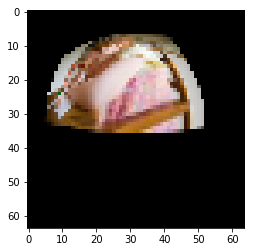

In [16]:
plt.figure()
plt.imshow(sensor.frame_view/256.)